# Obligatorisk innlevering 2 - oppgave 2

I denne oppgaven skal vi forsøke å forutsi oppsigelser ved en arbeidsplass basert på en rekke variabler som f.eks alder, kjønn, utdannelse, lønn, osv.

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, make_scorer, accuracy_score
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett2.csv")

### Preprosessering:
For å forenkle håndteringen av kategoriske data har jeg her skrevet noe kode som gjør om strenger til intergers

Følgende kolonner er formatert som *object* og inneholder kategoriske variabler i form av strenger

In [15]:
kolonner_obj = df.select_dtypes(include=['object']).columns
print(kolonner_obj)

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')


I koden under omformer jeg strengene til integers og gir dere "nøkkelen" til å konvertere det tilbake igjen

In [16]:
for i in kolonner_obj:
    print("-----------")
    print(i)
    print("-----------")
    for num, j in enumerate(list(df[i].unique())):
        print("{} = {}".format(j,num))
        df[i].loc[df[i]==j] = num
    df[i] = pd.to_numeric(df[i])

-----------
BusinessTravel
-----------
Travel_Frequently = 0
Travel_Rarely = 1
Non-Travel = 2
-----------
Department
-----------
Research & Development = 0
Sales = 1
Human Resources = 2
-----------
EducationField
-----------
Medical = 0
Other = 1
Marketing = 2
Life Sciences = 3
Technical Degree = 4
Human Resources = 5
-----------
Gender
-----------
Male = 0
Female = 1
-----------
JobRole
-----------
Laboratory Technician = 0
Sales Representative = 1
Sales Executive = 2
Healthcare Representative = 3
Manager = 4
Manufacturing Director = 5
Research Scientist = 6
Human Resources = 7
Research Director = 8
-----------
MaritalStatus
-----------
Married = 0
Divorced = 1
Single = 2
-----------
Over18
-----------
Y = 0
-----------
OverTime
-----------
Yes = 0
No = 1


C:\Users\Kasper\AppData\Local\Temp\ipykernel_7804\3482823818.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[i].loc[df[i]==j] = num
C:\Users\Kasper\AppData\Local\Temp\ipykernel_7804\3482823818.py:7: SettingWithCopyWarning: 
A value is

I outputen fra koden nedenfor viser datatypen til de forskjellige kolonnene, som nå etter preprosesseringen bare består av integers (int64). 

In [17]:
print(df.dtypes)

id                          int64
Age                         int64
BusinessTravel              int64
DailyRate                   int64
Department                  int64
DistanceFromHome            int64
Education                   int64
EducationField              int64
EmployeeCount               int64
EnvironmentSatisfaction     int64
Gender                      int64
HourlyRate                  int64
JobInvolvement              int64
JobLevel                    int64
JobRole                     int64
JobSatisfaction             int64
MaritalStatus               int64
MonthlyIncome               int64
MonthlyRate                 int64
NumCompaniesWorked          int64
Over18                      int64
OverTime                    int64
PercentSalaryHike           int64
PerformanceRating           int64
RelationshipSatisfaction    int64
StandardHours               int64
StockOptionLevel            int64
TotalWorkingYears           int64
TrainingTimesLastYear       int64
WorkLifeBalanc

In [18]:
# Her deler jeg datasettet inn i egenskaper (X) og target (y) (fjerner også den første kolonnen siden det bare er en ID 
# og har dermed ingen prediktiv verdi)

X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

# PS: Ikke endre denne kodecellen!

#### Oppgave 2.1) 
Visualiser $y\_train$ og $y\_val$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? Begrunn svaret

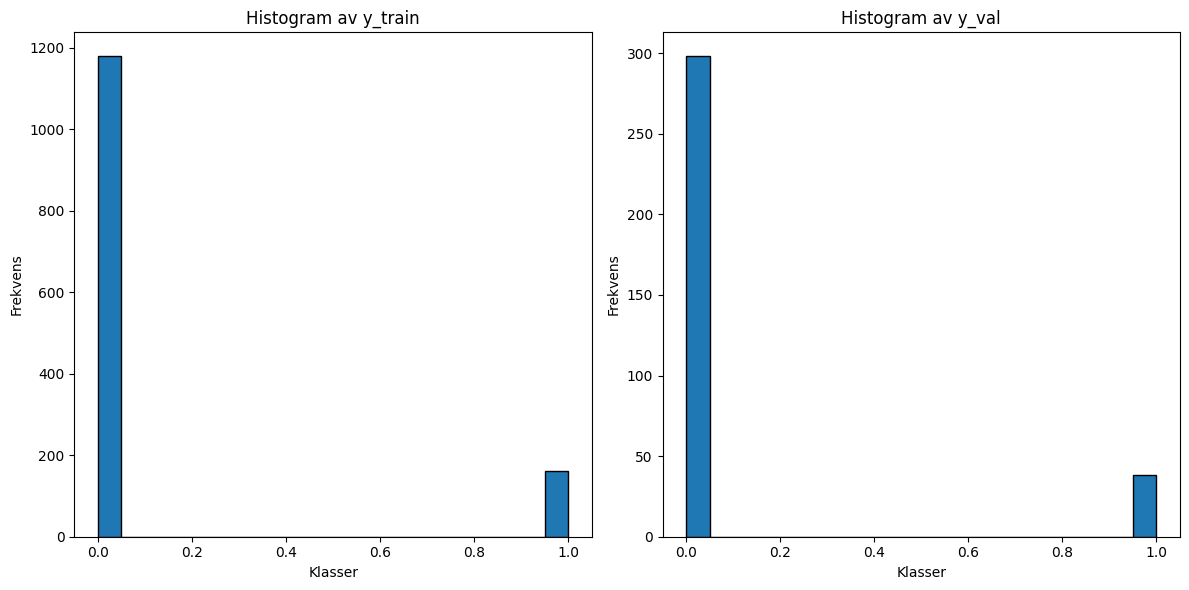

In [19]:
#TODO: visualiser y_train og y_test i et histogram

# Deler dataene i trenings- og valideringssett
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Visualisering av y_train og y_val
plt.figure(figsize=(12, 6))

# Histogram for y_train
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=20, edgecolor='black')
plt.title("Histogram av y_train")
plt.xlabel("Klasser")
plt.ylabel("Frekvens")

# Histogram for y_val
plt.subplot(1, 2, 2)
plt.hist(y_val, bins=20, edgecolor='black')
plt.title("Histogram av y_val")
plt.xlabel("Klasser")
plt.ylabel("Frekvens")

plt.tight_layout()
plt.show()

**Svar:**

*< Histogrammene for y_train og y_val viser at dataene er delt inn i diskrete klasser, noe som tyder på at dette er et klassifikasjonsproblem. Målet er å forutsi oppsigelser, som vanligvis er en binær klassifiseringsoppgave. >*

#### Oppgave 2.2)
Velg to modeller og gjør repeterte kryssvalideringer $(10)$ med $K=5$
* Velg hvorvidt du vil bruke "default" hyperparamtre for modellene eller om du vil gjøre et hyperparametersøk
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene skriftlig til slutt 


C:\Users\Kasper\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Kasper\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

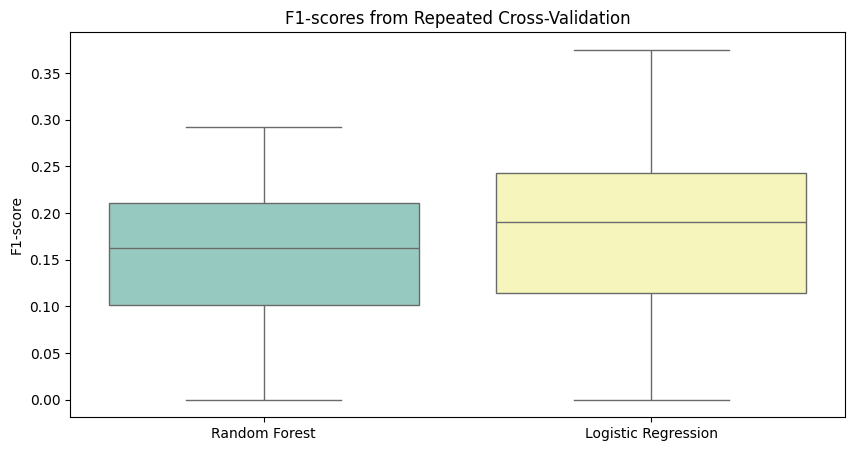

T-statistic: -2.1664027128036127
P-value: 0.03270523794605913


In [20]:
#TODO: repeterte kryssvalideringer for to modeller

# Konfigurerer
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)
scoring = {'f1': make_scorer(f1_score), 'accuracy': make_scorer(accuracy_score)}

# Modell 1 = RandomForestClassifier
model_1 = RandomForestClassifier(random_state=0)
f1_scores_1 = cross_val_score(model_1, X_train, y_train, cv=rkf, scoring='f1')
accuracy_scores_1 = cross_val_score(model_1, X_train, y_train, cv=rkf, scoring='accuracy')

# Modell 2 = LogisticRegression
model_2 = LogisticRegression(random_state=0, max_iter=1000)
f1_scores_2 = cross_val_score(model_2, X_train, y_train, cv=rkf, scoring='f1')
accuracy_scores_2 = cross_val_score(model_2, X_train, y_train, cv=rkf, scoring='accuracy')

# Visualisering 
plt.figure(figsize=(10, 5))
sns.boxplot(data=[f1_scores_1, f1_scores_2], palette="Set3")
plt.xticks([0, 1], ['Random Forest', 'Logistic Regression'])
plt.title("F1-scores from Repeated Cross-Validation")
plt.ylabel("F1-score")
plt.show()

# T-test
t_stat, p_value = ttest_ind(f1_scores_1, f1_scores_2)
print("T-statistic:", t_stat)
print("P-value:", p_value)

**Svar:**

*< T-testen gjør det mulig å vurdere om det er en statistisk signifikant forskjell mellom de to modellene. P-verdien avgjør om en av modellene konsekvent presterer bedre enn den andre. En lav p-verdi (< 0,05) indikerer at forskjellen mellom modellene er signifikant. >*

#### Oppgave 2.3) 
Tren de samme modellene men denne gangen med et balansert datasett
* Bruk imbalaced learn og SMOTE til å oppsample minioritetsklassen (bare oppsample treningsdataene i kryssvalideringen - ikke valideringsdataene)
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene og sammenlign resultatene med 2.2) 

C:\Users\Kasper\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Kasper\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/st

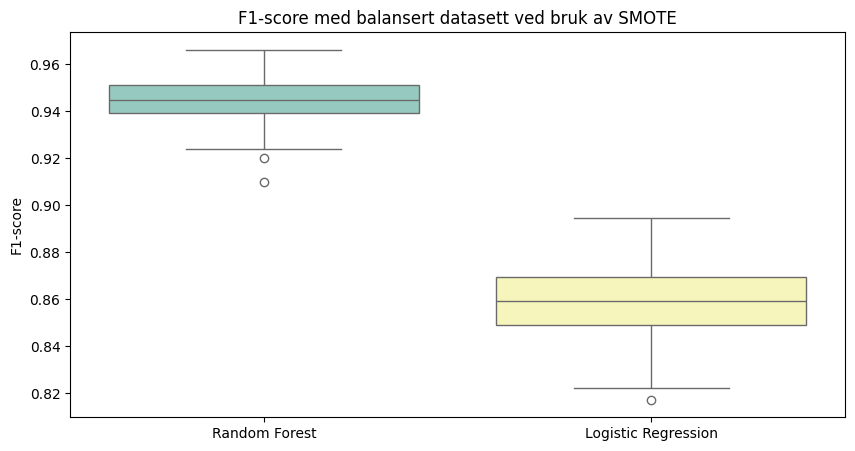

t-statistic: 30.938970515862433
p-value: 2.2501598016231864e-52


In [21]:
#TODO: repeterte kryssvalideringer for de samme to modellene som i oppgave 2.2, men denne gangen med SMOTE-oppsampling 
#from imblearn.over_sampling import SMOTE

# Oppsett med SMOTE
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Modell 1 
f1Scores1 = cross_val_score(model_1, X_resampled, y_resampled, cv=rkf, scoring='f1')
accuracyScore1 = cross_val_score(model_1, X_resampled, y_resampled, cv=rkf, scoring='accuracy')

# Modell 2 
f1_scores_2_balanced = cross_val_score(model_2, X_resampled, y_resampled, cv=rkf, scoring='f1')
accuracy_scores_2_balanced = cross_val_score(model_2, X_resampled, y_resampled, cv=rkf, scoring='accuracy')

# Visualisering av F1-skårer
plt.figure(figsize=(10, 5))
sns.boxplot(data=[f1Scores1, f1_scores_2_balanced], palette="Set3")
plt.xticks([0, 1], ['Random Forest', 'Logistic Regression'])
plt.title("F1-score med balansert datasett ved bruk av SMOTE")
plt.ylabel("F1-score")
plt.show()

# T-test
t_stat_balanced, p_value_balanced = ttest_ind(f1Scores1, f1_scores_2_balanced)
print("t-statistic:", t_stat_balanced)
print("p-value:", p_value_balanced)

**Svar:**

*< Etter å ha balansert datasettet med SMOTE, forbedrer begge modellene sine F1-skårer. Dette kan tyde på at oppsampling av minoritetsklassen gir modellene bedre evne til å forutsi oppsigelser mer nøyaktig.>*

#### Oppgave 2.4)
Tren den beste modellen på nytt og utfør prediksjon på testsettet. Mål nå ytelsen på testsettet ved bruk av sensitivitet, spesifisitet og presisjon, itillegg til F1-skår og accuracy

In [22]:
#TODO: Tren den beste modellen fra 2.2 og 2.3 på alle treningsdataene og test på testdataene

# Tren den beste modellen
beste_model = model_1.fit(X_train, y_train)
y_pred = beste_model.predict(X_test)

# Evaluer modellen på testsettet
report = classification_report(y_test, y_pred, target_names=['Ikke oppsigelse', 'oppsigelse'])
print(report)

# Konfusjonsmatrise
cm = confusion_matrix(y_test, y_pred)
print("Konfusjonsmatrise:\n", cm)

                 precision    recall  f1-score   support

Ikke oppsigelse       0.91      1.00      0.95       370
     oppsigelse       0.93      0.28      0.43        50

       accuracy                           0.91       420
      macro avg       0.92      0.64      0.69       420
   weighted avg       0.91      0.91      0.89       420

Konfusjonsmatrise:
 [[369   1]
 [ 36  14]]


Konfusjonsmatrisen viser hvor ofte modellen gjetter riktig/feil. I vårt tilfelle forutsier den 369 instanser av ikke oppsigelse som ikke oppsigelse. Den forutsa 1 ikke oppsigelse som oppsigelse. Den forutså 36 oppsigelser som var ikke oppsigelse. Tilsutt gjettet den riktig på 14 instanser av oppsigelse og det var oppsigelse. 

#### Oppgave 2.5)
Del opp testsettet basert på kjønn og gjør en analyse av sensitivitet, spesifisitet og presisjon for menn og det samme for kvinner. Skriv ut og diskuter resultatet og forsøk å svar på følgende spørsmål:
* Er modellen like god for begge kjønn? 
* Hvis ikke, hva tror du er årsaken og hvilke tiltak kan vi gjøre for å forbedre modellen? 

In [23]:
#TODO: Gjør kjønnsbasert analyse på testdataene
# Splitte testsettet etter kjønn
X_test_male = X_test[X_test['Gender'] == 0]
y_test_male = y_test[X_test['Gender'] == 0]
X_test_female = X_test[X_test['Gender'] == 1]
y_test_female = y_test[X_test['Gender'] == 1]

# Prediksjoner for menn og kvinner
y_pred_male = beste_model.predict(X_test_male)
y_pred_female = beste_model.predict(X_test_female)

# Ytelsesmetrikker for menn og kvinner
report_male = classification_report(y_test_male, y_pred_male, target_names=['Ikke oppsigelse', 'oppsigelse'])
print("Menn:\n", report_male)
report_female = classification_report(y_test_female, y_pred_female, target_names=['Ikke oppsigelse', 'oppsigelse'])
print("Kvinner:\n", report_female)



Menn:
                  precision    recall  f1-score   support

Ikke oppsigelse       0.89      1.00      0.94       217
     oppsigelse       0.91      0.28      0.43        36

       accuracy                           0.89       253
      macro avg       0.90      0.64      0.68       253
   weighted avg       0.89      0.89      0.87       253

Kvinner:
                  precision    recall  f1-score   support

Ikke oppsigelse       0.94      1.00      0.97       153
     oppsigelse       1.00      0.29      0.44        14

       accuracy                           0.94       167
      macro avg       0.97      0.64      0.71       167
   weighted avg       0.94      0.94      0.92       167



Utifra kjøringen kan vi se at store deler av modellen har høy treffsikkerhet. Det som modellen sliter mest med er å forutsi når det er oppsigelse. Dette gjelder både for menn og kvinner. Vi ser også at modellen fungerer ganske likt på både menn og kvinner.

Kjør denne cellen til slutt og legg ved den genererte requirements.txt fila i pull requestet

In [24]:
#!pip freeze > requirements.txt